In [1]:
import csv
import os
import pandas as pd
from urllib.request import urlopen
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

l2=[]
l3=[]
def loadfn(country,climtype):
    start_year=1920
    link="http://climatedataapi.worldbank.org/climateweb/rest/v1/country/mavg/miub_echo_g/"+climtype+"/1920/1939/"+country+".csv"
    with open(r"C:\\Users\\Admin\\"+country+climtype+".csv","w",newline='') as write_file:
        #open respective country file for editing . Respective file is created as ISO3codevar.csv where var is pr precipitation 
        #or tas as temperature
        f = csv.writer(write_file)
    write_file.close()
    response = urlopen(link)
    html = response.read().decode()
    with open("C:\\Users\\Admin\\"+country+climtype+".csv", "a",newline='') as write_file:
        #insert headers into the file. also insert an extra country field for convenience.
        f = csv.writer(write_file)
        lines = html.strip().split("\n")
        flag=0
        for l in lines:
            if (l[0] =="#"):
                continue;
            elif l[0:10] in ["Not Availa", "There is n"]:
                continue
            else: 
                l = l.split(",")
                #print(l)
                if(flag==0):
                    l.insert(0,"countries")
                    flag=1
                else:
                    l.insert(0,country)
                f.writerow(l)
        while(start_year!=2080):
            start_year=start_year+20
            #changing year changes the api link and helps access different yearly data for corresponding country
            link="http://climatedataapi.worldbank.org/climateweb/rest/v1/country/mavg/miub_echo_g/"+climtype+"/"+str(start_year)+"/"+str(start_year+19)+"/"+country+".csv"
            response = urlopen(link)
            html = response.read().decode()
            lines = html.strip().split("\n")
            for l in lines[1:]:
                    if l[0] =="#":
                        continue
                    elif l[0:10] in ["Not Availa", "There is n"]: #prevent it from writing lines  where no data is present (i.e. returns saying - "Not Available" or "There is no weather data available for the date provided. Past data is available from 1 July, 2008 onwards only.")
                        continue
                    elif l[15:17] in ["b1"]: 
                        continue;
                    elif l[16:18] in ["b1"]:
                        continue;
                    else:
                        if ((l[15:17] in ["a2"]) or (l[16:18] in ["a2"])):
                            l=l.replace("a2,",'')
                        #Multiple entries for different data sources were available as b1 or a2. 
                        #we picked the a2 data and discarded the b1 data.we also discarded the tokens themselves
                        #since we were using only a2 data for every country.
                        l = l.split(",")
                        #fill in missing values 2000 to 2020 other values write to file directly
                        if(int(l[2])<1980 or int(l[2])>2020):
                            l.insert(0,country)
                            f.writerow(l)
                        elif(int(l[2])==1980):
                            l2=l
                            l.insert(0,country)
                            f.writerow(l)
                        elif(int(l[2])==2020):
                            l3=[l[0],l[1],"2000","2020"]
                            l3+=[str((float(x)+float(y))/2) for x,y in zip(l2[5:],l[4:])] #find avg of previous and future years
                            l3.insert(0,country)
                            l.insert(0,country)
                            f.writerow(l3)
                            f.writerow(l)
                            
    write_file.close()

#### We can select any countries by adding or removing countries to "_lcountries_" according to their *ISO3* code. 

This was done because the api links depended on *ISO3* code instead of simple names(GBR instead of Great BRitian)
lSO3 code of countries can be checked here https://unstats.un.org/unsd/methodology/m49/

In [2]:
#This list can be changed by adding or removing any country's ISO code which the api link depends on
lcountries=["USA","CHN","GBR","AUS"]
for countries in lcountries:
    loadfn(countries,"pr")
    loadfn(countries,"tas")

Next we extracted the data from all saved csv's and added it to a single dataframe (countryframe) for easy access. This frame now contains data of all countries specified in lcountries.

In [14]:
li=[]
for countries in lcountries:
    dfcountrytemp = pd.read_csv('C:\\Users\\Admin\\'+countries+'tas.csv', index_col="from_year", header=0)
    dfcountryvar = pd.read_csv('C:\\Users\\Admin\\'+countries+'pr.csv', index_col="from_year", header=0)
    li.append(dfcountrytemp)
    li.append(dfcountryvar)
countryframe = pd.concat(li, axis=0)
print(countryframe)

          countries          GCM  var  to_year         Jan         Feb  \
from_year                                                                
1920            USA  miub_echo_g  tas     1939   -5.571299   -4.362196   
1940            USA  miub_echo_g  tas     1959   -5.732263   -4.193626   
1960            USA  miub_echo_g  tas     1979   -5.091785   -4.177431   
1980            USA  miub_echo_g  tas     1999   -4.668362   -4.219703   
2000            USA  miub_echo_g  tas     2020   -4.243885   -3.557529   
2020            USA  miub_echo_g  tas     2039   -3.819408   -2.895354   
2040            USA  miub_echo_g  tas     2059   -2.739642   -1.472574   
2060            USA  miub_echo_g  tas     2079   -1.460896   -0.560847   
2080            USA  miub_echo_g  tas     2099   -0.052156    0.703150   
1920            USA  miub_echo_g   pr     1939   66.385622   58.406359   
1940            USA  miub_echo_g   pr     1959   64.640290   56.583557   
1960            USA  miub_echo_g   pr 

Next we spliced countries depending on the precipitation and temperature seperately. we averaged this and plotted the average yearly by taking the mean along the row.

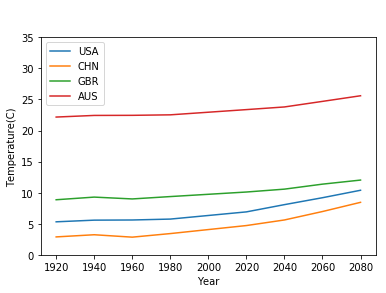

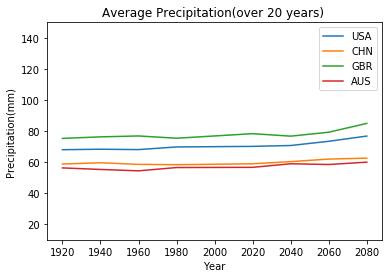

In [12]:
l4=[]
l5=[]
for countryvar in lcountries:
    tc=countryframe[(countryframe['countries'] == countryvar) & (countryframe['var'] == "tas")]
    pc=countryframe[(countryframe['countries'] == countryvar) & (countryframe['var'] == "pr")]
    plt.figure(0)
    tc.loc[:,"Jan"::1].mean(axis=1).plot(label=countryvar)
    plt.title("Average temperature(over 20 years)")
    plt.ylim(0,35)
    plt.title("\n")
    plt.ylabel("Temperature(C)")
    plt.xlabel("Year")
    plt.legend()
    l4.append(tc.loc[:,"Jan"::1].mean(axis=1).mean())
    plt.figure(1)
    pc.loc[:,"Jan"::1].mean(axis=1).plot(label=countryvar)
    plt.ylim(10,150)
    plt.title("Average Precipitation(over 20 years) ")
    plt.ylabel("Precipitation(mm) ")
    plt.xlabel("Year")
    plt.legend()
    l5.append(pc.loc[:,"Jan"::1].mean(axis=1).mean())


We also showed the avg temperature per month. to see if there are any common changes for different countries.
This was achieved by simply splicing along the column. and taking the mean.

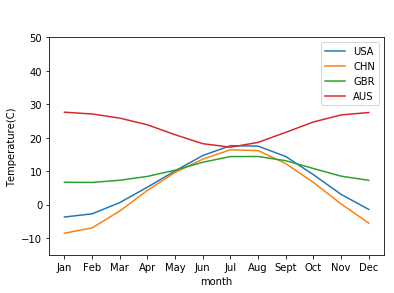

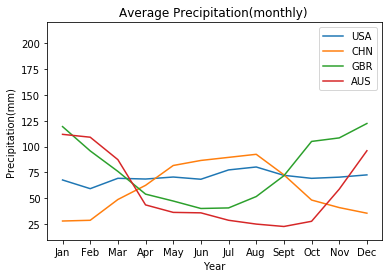

In [6]:
for countryvar in lcountries:  
    tc=countryframe[(countryframe['countries'] == countryvar) & (countryframe['var'] == "tas")]
    pc=countryframe[(countryframe['countries'] == countryvar) & (countryframe['var'] == "pr")]
    plt.figure(2)
    tc.loc[:,"Jan"::1].mean().plot(label=countryvar)
    plt.title("Average temperature(Monthly)")
    plt.ylim(-15,50)
    plt.title("\n")
    plt.xticks(range(12),["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"])
    plt.legend()
    plt.ylabel("Temperature(C)")
    plt.xlabel("month")

    
    plt.figure(3)
    pc.loc[:,"Jan"::1].mean().plot(label=countryvar)
    plt.ylim(10,220)
    plt.xticks(range(12),["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"])
    plt.title("Average Precipitation(monthly) ")
    plt.ylabel("Precipitation(mm) ")
    plt.xlabel("Year")
    plt.legend()
    

To show the overall temperature we took the mean twice. to compare overall attributes of the countries.

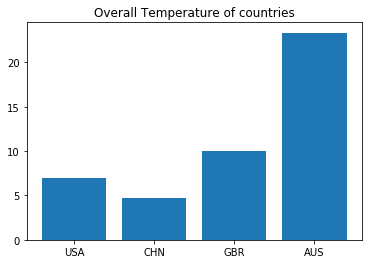

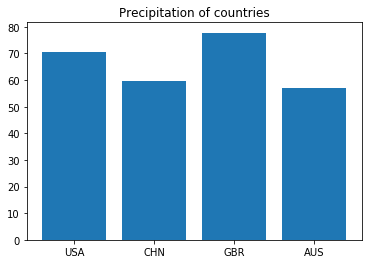

In [13]:

plt.figure(4)
plt.title("Overall Temperature of countries")
plt.bar(lcountries,l4)
plt.figure(5)
plt.title("Precipitation of countries")
plt.bar(lcountries,l5)
plt.show()

Next we plotted all the data obtained for every country seperately to find if there are any trends in the data.
For most countries there was an exponential or a linear rise in precipitation as temperature increased. Not all countries followed this trend as Great britian (GBR) the trend was weak and the precipitation decreased as the temperature increased.

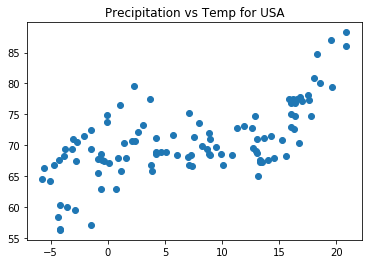

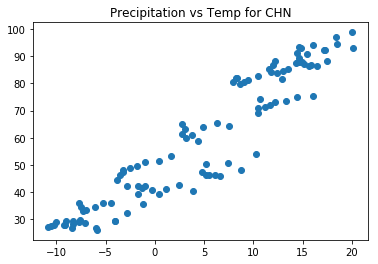

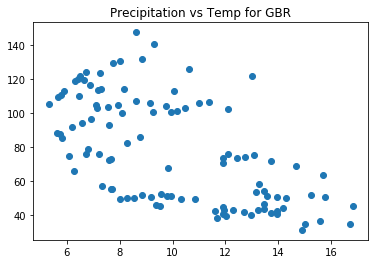

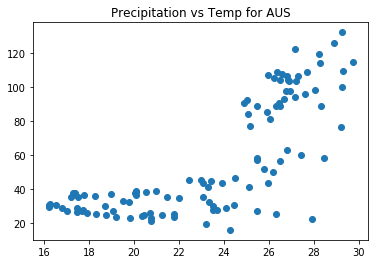

In [9]:
#figno is used to keep track of the plots to draw as seperate countries . the lcountries is dynamic and figno
#accomodates this and creates appropriate no. of plots.
figno=6
for countryvar in lcountries:
    tc=countryframe[(countryframe['countries'] == countryvar) & (countryframe['var'] == "tas")]
    pc=countryframe[(countryframe['countries'] == countryvar) & (countryframe['var'] == "pr")]
    plt.figure(figno)
    figno+=1
    plt.scatter(tc.loc[:,"Jan"::1].values.tolist(),pc.loc[:,"Jan"::1].values.tolist())
    plt.title("Precipitation vs Temp for "+countryvar)